# TF isoform data


## TODO

- check valid clones only in all data
- get sequence information
- remove partners that didn't test positive with any isoform
- remove single isoforms
    - but need to add first to paralogs
- Look into effect of number of PPIs per TF
- combine categories to get paralog data

In [1]:
import os
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

import ccsblib
from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_seq_comparison_data)
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table

%matplotlib inline

y2h = load_isoform_and_paralog_y2h_data()
y1h = load_y1h_pdi_data()
# m1h = load_m1h_activation_data()
isoforms = load_valid_isoform_clones()
idents = load_seq_comparison_data()

#tfs = tfs.drop(columns=['tpm_stdev'])
#tfs = tfs.set_index(['gene', 'isoacc', 'tiss'])
#tfs = tfs.unstack(level='tiss')
#tfs.columns = tfs.columns.get_level_values(1)

#tfs.to_csv('tf_isoform_tissue_tpms.tsv', sep='\t')

In [2]:
y2h.head()

,large_plate_name,retest_pla,retest_pos,ad_gene_symbol,ad_clone_name,ad_orf_id,db_gene_symbol,db_orf_id,category,3AT,LW,empty_AD_3AT,empty_AD_LW,Y2H_result,seq_confirmation_3AT,seq_confirmation_LW,ad_clone_acc
0,TFfnlr07_001_002_003_004_005_006,5,A01,ATF2,ATF2-1,101414,ATF2,54731,tf_isoform_ppis,2,4,0,4,True,True,True,ATF2|1/6|12H04
1,TFfnlr07_001_002_003_004_005_006,5,A02,ATF2,ATF2-1,101414,COL8A1,3053,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|1/6|12H04
2,TFfnlr07_001_002_003_004_005_006,5,A03,ATF2,ATF2-1,101414,EFEMP2,2906,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|1/6|12H04
3,TFfnlr07_001_002_003_004_005_006,5,A04,ATF2,ATF2-1,101414,FOSL2,12504,tf_isoform_ppis,2,4,0,4,NaN,False,True,ATF2|1/6|12H04
4,TFfnlr07_001_002_003_004_005_006,5,A05,ATF2,ATF2-1,101414,JDP2,13624,tf_isoform_ppis,2,4,0,4,True,True,True,ATF2|1/6|12H04


In [3]:
print('Numbers for the isoform experiment (not paralogs or controls):')
print(y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
        'ad_clone_acc'].nunique(),
      'isoforms attempted to test for PPIs')
print(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
        (y2h['Y2H_result'].notnull()),
        'ad_clone_acc'].nunique(),
        'isoforms successfully tested for at least one PPI')
print(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
              (y2h['Y2H_result'] == True),
        'ad_clone_acc'].nunique(),
        'isoforms with at least one positive PPI')
print(((y2h['category'] == 'tf_isoform_ppis') &
        (y2h['Y2H_result'] == True)).sum(),
        'positive PPIs, involving',
        y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                (y2h['Y2H_result'] == True), 'db_gene_symbol'].nunique(),
        'protein partners')

Numbers for the isoform experiment (not paralogs or controls):
308 isoforms attempted to test for PPIs
287 isoforms successfully tested for at least one PPI
200 isoforms with at least one positive PPI
2259 positive PPIs, involving 574 protein partners


In [4]:
yang = pd.read_excel('../data/external/Yang_et_al_Cell_2014_Table_S2.xlsx',
                     sheet_name='2B-Isoform PPIs')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
# isoforms with >= 2 tested and at least one positive PPI
# count pairwise combinations and genes
yang['2_or_more_iso_per_gene'] = yang['Gene_Symbol'].map((yang.groupby('Gene_Symbol')['Isoform_ID'].nunique() > 1))

In [6]:
yang['2_or_more_partners_per_iso'] = yang['Isoform_ID'].map(yang['Isoform_ID'].value_counts() >= 2)

In [7]:
yang['2_or_more_iso_with_2_or_more_partners_per_gene'] = yang['Gene_Symbol'].map(yang.loc[yang    ['2_or_more_partners_per_iso'], 
         :].groupby('Gene_Symbol')['Isoform_ID'].nunique() >= 2).fillna(False)

In [8]:
yang.loc[yang['2_or_more_iso_with_2_or_more_partners_per_gene'], 'Gene_Symbol'].nunique()

87

In [9]:
import itertools

def count_pairs_per_gene(df):
    pairs_count = 0
    for iso_a, iso_b in itertools.combinations(df['Isoform_ID'].unique(), 2):
        if (((df['Isoform_ID'] == iso_a) & (df['Interaction_Found'] == 'positive')).any()
            and ((df['Isoform_ID'] == iso_b) & (df['Interaction_Found'] == 'positive')).any()
            and len(set(df.loc[df['Isoform_ID'] == iso_a, 'Interactor_ID']).intersection(set(df.loc[df['Isoform_ID'] == iso_b, 'Interactor_ID']))) >= 2):
            pairs_count += 1
    return pairs_count

iso_pairs_per_gene = yang.groupby('Gene_Symbol').apply(count_pairs_per_gene)
print(iso_pairs_per_gene.sum(), (iso_pairs_per_gene >= 1).sum())

100 65


In [10]:
yang.loc[yang['2_or_more_iso_with_2_or_more_partners_per_gene'], :]

,Entrez_Gene_ID,Gene_Symbol,Isoform_ID,Category,Interactor_Entrez_Gene_ID,Interactor_Symbol,Interactor_ID,Interaction_Found,2_or_more_iso_per_gene,2_or_more_partners_per_iso,2_or_more_iso_with_2_or_more_partners_per_gene
0,81,ACTN4,ACTN4_1,reference,373,TRIM23,TRIM23,negative,True,True,True
1,81,ACTN4,ACTN4_1,reference,51778,MYOZ2,MYOZ2,positive,True,True,True
2,81,ACTN4,ACTN4_4,alternative,373,TRIM23,TRIM23,positive,True,True,True
3,81,ACTN4,ACTN4_4,alternative,51778,MYOZ2,MYOZ2,negative,True,True,True
4,207,AKT1,AKT1_1,reference,8115,TCL1A,TCL1A,positive,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
2021,387032,ZKSCAN4,ZKSCAN4_3,alternative,84547,PGBD1,PGBD1,NaN,True,True,True
2022,387032,ZKSCAN4,ZKSCAN4_3,alternative,84838,ZNF496,ZNF496,positive,True,True,True
2023,387032,ZKSCAN4,ZKSCAN4_3,alternative,158399,ZNF483,ZNF483,positive,True,True,True
2024,387032,ZKSCAN4,ZKSCAN4_3,alternative,342945,ZSCAN22,ZSCAN22,positive,True,True,True


In [11]:
isoforms['gene'].nunique()

310

In [12]:
isoforms.shape

(758, 7)

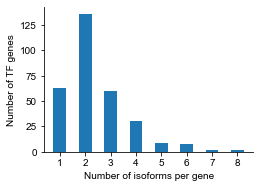

In [13]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.5, 2.5)
isoforms['gene'].value_counts().plot.hist(ax=ax, range=(0.75, 8.25), bins=15)
ax.set_ylabel('Number of TF genes')
ax.set_xlabel('Number of isoforms per gene')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(range(1, 9))
plt.savefig('../figures/isoform_clones_per_tf_gene.pdf',
            bbox_inches='tight')

In [14]:
from data_loading import load_tf_families
all_tfs = load_tf_families()
all_tfs.shape[0]

1639

In [15]:
iso_y1h_pos = set(y1h.loc[y1h[y1h.columns[2:]].any(axis=1), 'unique_acc'].values)

In [16]:
iso_gte_1_pos_ppi_iso_data_only = set(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['Y2H_result'] == True), 'ad_clone_acc'].unique()) 
iso_gte_1_pos_ppi_all_data = set(y2h.loc[(y2h['Y2H_result'] == True), 'ad_clone_acc'].unique())
pos_in_only_non_isoform_ppi_data = iso_gte_1_pos_ppi_all_data.difference(iso_gte_1_pos_ppi_iso_data_only)
print(len(pos_in_only_non_isoform_ppi_data),
      'isoforms that are Y2H positive in a dataset outside the isoform')
print(pos_in_only_non_isoform_ppi_data)
y2h.loc[(y2h['ad_clone_acc'].isin(pos_in_only_non_isoform_ppi_data)) & (y2h['Y2H_result'] == True), :]

4 isoforms that are Y2H positive in a dataset outside the isoform
{'PKNOX1|4/4|06G03', 'ELF2|2/4|04E01', 'PKNOX1|3/4|06H03', 'NFAT5|1/2|02F01'}


,large_plate_name,retest_pla,retest_pos,ad_gene_symbol,ad_clone_name,ad_orf_id,db_gene_symbol,db_orf_id,category,3AT,LW,empty_AD_3AT,empty_AD_LW,Y2H_result,seq_confirmation_3AT,seq_confirmation_LW,ad_clone_acc
1085,TFfnlr07_025_026_027_028_029_030,30,B01,ELF2,ELF2-2,100179,BANP,6534,non_paralog_control,2,4,0,4,True,True,True,ELF2|2/4|04E01
3115,TFfnlr07_067_068_069_070_071_072,67,C05,PKNOX1,PKNOX1-3,100276,CCDC196,14908,tf_paralog_ppis,2,4,0,4,True,True,True,PKNOX1|3/4|06H03
3127,TFfnlr07_067_068_069_070_071_072,67,D05,PKNOX1,PKNOX1-4,100240,CCDC196,14908,tf_paralog_ppis,2,4,0,4,True,True,True,PKNOX1|4/4|06G03
4797,TFfnlr07_097_098_099_xxx_xxx_xxx,98,E10,NFAT5,NFAT5-1,101044,ING3,14384,rrs_isoforms,2,4,0,4,True,True,True,NFAT5|1/2|02F01


In [17]:
y2h = load_isoform_and_paralog_y2h_data()
# restict to TF isoform data (i.e. not paralogs etc.)
ppi = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['category',
               'ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'Y2H_result']].copy()
# at least one positive per PPI partner
ppi = ppi.loc[ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['Y2H_result']
                 .transform(lambda row: (row == True).any()),
              :]
# at least one successfully tested PPI per isoform
ppi = ppi.loc[ppi.groupby('ad_clone_acc')
                  ['Y2H_result']
                  .transform(lambda x: (x.notnull().any())),
              :]
# at least two partners per isoform
ppi = ppi.loc[ppi.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
isoforms = load_valid_isoform_clones()
iso_pairs = pairs_of_isoforms_comparison_table(isoforms=isoforms,
                                               y2h=ppi,
                                               y1h=y1h,
                                               m1h=m1h)
iso_pairs['both_iso_y2h_pos'] = (iso_pairs['clone_acc_a'].isin(iso_gte_1_pos_ppi_iso_data_only) &
                                 iso_pairs['clone_acc_b'].isin(iso_gte_1_pos_ppi_iso_data_only))
iso_pairs['both_iso_y2h_pos_all_data'] = (iso_pairs['clone_acc_a'].isin(iso_gte_1_pos_ppi_all_data) &
                                          iso_pairs['clone_acc_b'].isin(iso_gte_1_pos_ppi_all_data))

In [18]:
iso_pairs['both_iso_y2h_or_y1h_pos'] = (iso_pairs['clone_acc_a'].isin(iso_gte_1_pos_ppi_all_data.union(iso_y1h_pos)) &
                                        iso_pairs['clone_acc_b'].isin(iso_gte_1_pos_ppi_all_data.union(iso_y1h_pos)))

In [19]:
iso_pairs['isoform_a'] = iso_pairs['clone_acc_a'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
iso_pairs['isoform_b'] = iso_pairs['clone_acc_b'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [20]:
iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2)
               & iso_pairs['both_iso_y2h_pos_all_data'], :].shape

(159, 29)

In [21]:
genes_nonzero_pair = set(iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2)
               & iso_pairs['both_iso_y2h_pos_all_data'] , 'tf_gene_symbol'].unique())
len(genes_nonzero_pair)

56

In [22]:
iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2) &
              iso_pairs['both_iso_y2h_or_y1h_pos'], :].shape

(174, 29)

In [23]:
# Y1H rescue
genes_y1h_rescue = set(iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2) &
                     iso_pairs['both_iso_y2h_or_y1h_pos'],
                     'tf_gene_symbol'].unique())
print(len(genes_y1h_rescue))
print(genes_y1h_rescue.difference(genes_nonzero_pair))

60
{'PRRX1', 'MEIS1', 'FOXJ2', 'RARG'}


In [24]:
rescue_pairs = iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2) &
              (iso_pairs['both_iso_y2h_or_y1h_pos'] ^
               iso_pairs['both_iso_y2h_pos_all_data']), :]
rescue_iso = set(rescue_pairs[['clone_acc_a', 'clone_acc_b']].values.flatten()).difference(iso_gte_1_pos_ppi_all_data)
print(len(rescue_iso))
print(rescue_iso)
rescue_pairs

11
{'PRRX1|3/3|09H08', 'GRHL3|2/7|08A10', 'PRRX1|2/3|09F06', 'RARG|1/2|08F10', 'WT1|6/6|10G06', 'NFIX|4/4|08D05', 'MEIS1|2/2|09G04', 'HNF4A|4/6|10A10', 'GRHL3|6/7|08G10', 'PPARG|4/4|10H03', 'FOXJ2|2/2|06B11'}


,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOXJ2|1/2|06F10_FOXJ2|2/2|06B11,FOXJ2,FOXJ2|1/2|06F10,FOXJ2|2/2|06B11,2.0,0.0,0.0,0.0,0.0,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.167440,6.550576,-5.383136,5.383136,89.7,False,False,True,FOXJ2-1,FOXJ2-2
GRHL3|2/7|08A10_GRHL3|3/7|08G09,GRHL3,GRHL3|2/7|08A10,GRHL3|3/7|08G09,2.0,0.0,0.0,0.0,0.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.248480,0.436213,0.187733,0.187733,98.4,False,False,True,GRHL3-2,GRHL3-3
GRHL3|3/7|08G09_GRHL3|6/7|08G10,GRHL3,GRHL3|3/7|08G09,GRHL3|6/7|08G10,2.0,0.0,0.0,0.0,0.0,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155513,0.436213,-0.280700,0.280700,84.5,False,False,True,GRHL3-3,GRHL3-6
HNF4A|1/6|10D08_HNF4A|4/6|10A10,HNF4A,HNF4A|1/6|10D08,HNF4A|4/6|10A10,2.0,0.0,0.0,0.0,0.0,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.6,False,False,True,HNF4A-1,HNF4A-4
MEIS1|1/2|09A04_MEIS1|2/2|09G04,MEIS1,MEIS1|1/2|09A04,MEIS1|2/2|09G04,6.0,0.0,0.0,0.0,0.0,NaN,6.0,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.243943,-0.954097,-0.289846,0.289846,78.3,False,False,True,MEIS1-1,MEIS1-2
NFIX|1/4|08H03_NFIX|4/4|08D05,NFIX,NFIX|1/4|08H03,NFIX|4/4|08D05,2.0,0.0,0.0,0.0,0.0,NaN,2.0,-2.0,3.0,3.0,3.0,0.0,1.000000,1.0,0.0,0.0,1.314330,2.371762,1.057432,1.057432,75.3,False,False,True,NFIX-1,NFIX-4
NFIX|2/4|08G06_NFIX|4/4|08D05,NFIX,NFIX|2/4|08G06,NFIX|4/4|08D05,2.0,0.0,0.0,0.0,0.0,NaN,2.0,-2.0,4.0,3.0,3.0,0.0,0.750000,1.0,1.0,-1.0,1.678508,2.371762,0.693253,0.693253,73.2,False,False,True,NFIX-2,NFIX-4
NFIX|3/4|08F05_NFIX|4/4|08D05,NFIX,NFIX|3/4|08F05,NFIX|4/4|08D05,2.0,0.0,0.0,0.0,0.0,NaN,2.0,-2.0,3.0,1.0,1.0,0.0,0.333333,1.0,2.0,2.0,2.251593,2.371762,0.120169,0.120169,80.0,False,False,True,NFIX-3,NFIX-4
PPARG|1/4|10G02_PPARG|4/4|10H03,PPARG,PPARG|1/4|10G02,PPARG|4/4|10H03,6.0,0.0,0.0,0.0,0.0,NaN,6.0,-6.0,2.0,1.0,1.0,0.0,0.500000,1.0,1.0,-1.0,0.801302,2.423347,-1.622045,1.622045,48.5,False,False,True,PPARG-1,PPARG-4


In [25]:
(iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2)
               & iso_pairs['both_iso_y2h_pos_all_data'] , 
               ['tf_gene_symbol', 'isoform_a', 'isoform_b', 'ppi_n_tested',
       'ppi_n_shared', 'ppi_n_min', 'ppi_jaccard']]
               .to_csv('../output/non_zero_isoform_pairs.tsv',
               index=False,
               sep='\t'))

In [26]:
iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2)
               & ~iso_pairs['both_iso_y2h_pos']
               & iso_pairs['both_iso_y2h_pos_all_data'], :]

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ELF2|1/4|03A11_ELF2|2/4|04E01,ELF2,ELF2|1/4|03A11,ELF2|2/4|04E01,2.0,0.0,0.0,0.0,0.0,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.745244,6.025830,-3.280586,3.280586,79.8,False,True,True,ELF2-1,ELF2-2
PKNOX1|1/4|11H11_PKNOX1|3/4|06H03,PKNOX1,PKNOX1|1/4|11H11,PKNOX1|3/4|06H03,4.0,0.0,0.0,0.0,0.0,NaN,4.0,-4.0,9.0,2.0,2.0,0.0,0.222222,1.0,7.0,7.0,NaN,NaN,NaN,NaN,73.2,False,True,True,PKNOX1-1,PKNOX1-3
PKNOX1|1/4|11H11_PKNOX1|4/4|06G03,PKNOX1,PKNOX1|1/4|11H11,PKNOX1|4/4|06G03,3.0,0.0,0.0,0.0,0.0,NaN,3.0,-3.0,9.0,1.0,2.0,1.0,0.111111,0.5,8.0,6.0,NaN,NaN,NaN,NaN,72.9,False,True,True,PKNOX1-1,PKNOX1-4
PKNOX1|2/4|06H05_PKNOX1|3/4|06H03,PKNOX1,PKNOX1|2/4|06H05,PKNOX1|3/4|06H03,4.0,0.0,0.0,0.0,0.0,NaN,4.0,-4.0,9.0,1.0,1.0,0.0,0.111111,1.0,8.0,8.0,1.482472,2.368409,-0.885937,0.885937,72.9,False,True,True,PKNOX1-2,PKNOX1-3
PKNOX1|2/4|06H05_PKNOX1|4/4|06G03,PKNOX1,PKNOX1|2/4|06H05,PKNOX1|4/4|06G03,3.0,0.0,0.0,0.0,0.0,NaN,3.0,-3.0,9.0,0.0,1.0,1.0,0.000000,0.0,9.0,7.0,1.414036,2.368409,-0.954373,0.954373,73.1,False,True,True,PKNOX1-2,PKNOX1-4


In [27]:
iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2)
               & iso_pairs['both_iso_y2h_pos'] &
    (iso_pairs['both_iso_y2h_pos_all_data'] ^ iso_pairs['both_iso_y2h_pos']), :]

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [28]:
ppi 

,category,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,tf_isoform_ppis,ATF2|1/6|12H04,ATF2,ATF2,True
3,tf_isoform_ppis,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,tf_isoform_ppis,ATF2|1/6|12H04,ATF2,JDP2,True
12,tf_isoform_ppis,ATF2|2/6|09E05,ATF2,ATF2,True
15,tf_isoform_ppis,ATF2|2/6|09E05,ATF2,FOSL2,NaN
...,...,...,...,...,...
10278,tf_isoform_ppis,TCF12|1/3|07D07,TCF12,FAM50B,True
10283,tf_isoform_ppis,TCF12|2/3|07A09,TCF12,EPHB6,False
10290,tf_isoform_ppis,TCF12|2/3|07A09,TCF12,FAM50B,True
10295,tf_isoform_ppis,TCF12|3/3|07B07,TCF12,EPHB6,False


In [29]:
iso_pairs['pdi_n_max'] = iso_pairs['pdi_n_tested'] - (iso_pairs['pdi_n_min'] - iso_pairs['pdi_n_shared'])

In [30]:
iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(),
              ['tf_gene_symbol',
               'clone_acc_a',
               'clone_acc_b',
               'pdi_jaccard',
               'pdi_n_min',
               'pdi_n_max']].to_csv('../output/PDI_isoform_pairs.tsv', sep='\t', index=False)

In [31]:
iso_pairs.shape

(804, 30)

In [32]:
(isoforms.groupby('gene').size() >= 2).sum()

247

In [33]:
iso_pairs.notnull().sum()

tf_gene_symbol                804
clone_acc_a                   804
clone_acc_b                   804
ppi_n_tested                  292
ppi_n_shared                  292
ppi_n_min                     292
ppi_n_min_diff                292
ppi_jaccard                   292
ppi_simpson                   171
ppi_n_diff                    292
ppi_delta_n                   292
pdi_n_tested                  132
pdi_n_shared                  132
pdi_n_min                     132
pdi_n_min_diff                132
pdi_jaccard                   132
pdi_simpson                    70
pdi_n_diff                    132
pdi_delta_n                   132
m1h_min                       614
m1h_max                       614
activation_fold_change        614
activation_abs_fold_change    614
aa_seq_pct_id                 804
both_iso_y2h_pos              804
both_iso_y2h_pos_all_data     804
both_iso_y2h_or_y1h_pos       804
isoform_a                     804
isoform_b                     804
pdi_n_max     

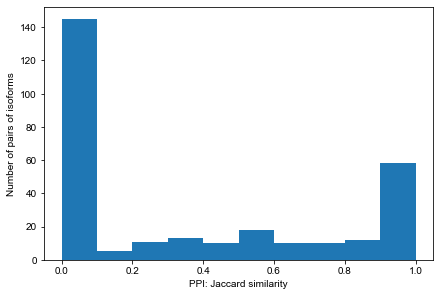

In [34]:
fig, ax = plt.subplots(1, 1)
ax.hist(iso_pairs['ppi_jaccard'], range=(0, 1), bins=10)
ax.set_ylabel('Number of pairs of isoforms')
ax.set_xlabel('PPI: Jaccard similarity')
plt.savefig('../figures/ppi_jaccard_dist.pdf')

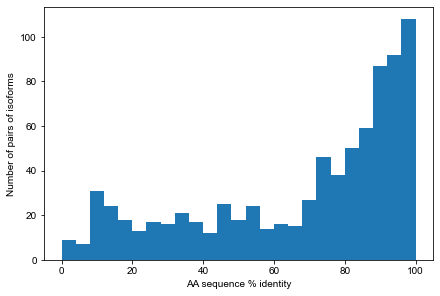

In [35]:
fig, ax = plt.subplots(1, 1)
ax.hist(iso_pairs['aa_seq_pct_id'], range=(0, 100), bins=25)
ax.set_ylabel('Number of pairs of isoforms')
ax.set_xlabel('AA sequence % identity')
plt.savefig('../figures/aa_seq_pct_id_hist.pdf')

In [36]:
#for col in iso_pairs.columns[4:]:
#    plt.hist(iso_pairs[col], bins=30)
#    plt.xlabel(col)
#    plt.ylabel('count')
#    plt.show()

In [37]:
iso_pairs.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,pdi_n_max
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AEBP2|2/3|05F03_AEBP2|3/3|05E07,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.234322,0.301297,-0.535619,0.535619,82.0,False,False,False,AEBP2-2,AEBP2-3,NaN
ARNT2|1/6|08C12_ARNT2|2/6|09E01,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,10.0,6.0,6.0,0.0,0.6,1.0,4.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.337698,4.432498,-2.094800,2.094800,93.0,True,True,True,ARNT2-1,ARNT2-2,NaN
ARNT2|1/6|08C12_ARNT2|3/6|10D11,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.7,False,False,False,ARNT2-1,ARNT2-3,NaN
ARNT2|2/6|09E01_ARNT2|3/6|10D11,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1,False,False,False,ARNT2-2,ARNT2-3,NaN
ARNTL|1/2|08H08_ARNTL|2/2|08E08,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,2.0,0.0,0.0,0.0,0.0,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.3,False,False,False,ARNTL-1,ARNTL-2,NaN


### Explore PDI/PPI profile differences and sequence similarity

Look into:
- PPI and PDI Jaccard distribution
  - Faceted by degree
- PPI versus PDI Jaccard/Simpson
  - Faceted by number of interactors
- PPI/PDI Jaccard versus sequence similarity

TODO
- Compare randomly selected isoforms from different genes (from paralog data)

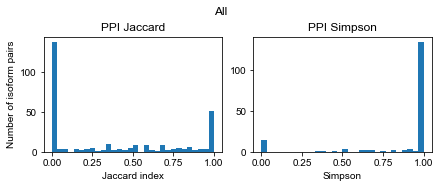

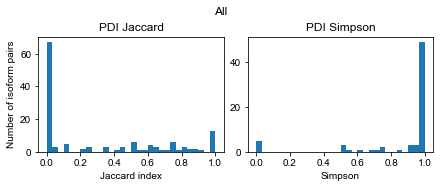

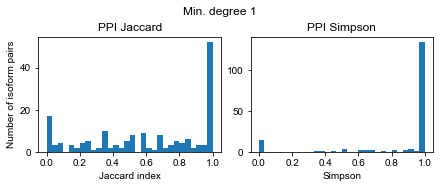

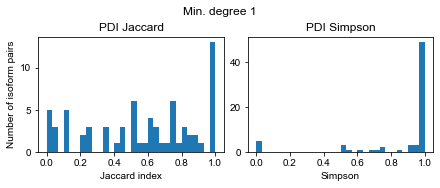

In [38]:
#  Jaccard/Simpson for PPI/PDI, histograms
def make_jaccard_simpson_hist(int_type, iso_pairs=iso_pairs, main_title='', nb=30):
    # int_type - ppi or pdi
    # nb - number of bins
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2.5))
    fig.suptitle(main_title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.87]) # adjust to allow for subtitle

    ax1.hist(iso_pairs[int_type + '_jaccard'], bins=nb)
    ax1.set_title(int_type.upper() + ' Jaccard')
    ax1.set_xlabel('Jaccard index')
    ax1.set_ylabel('Number of isoform pairs')
    
    ax2.hist(iso_pairs[int_type + '_simpson'], bins=nb)
    ax2.set_title(int_type.upper() + ' Simpson')
    ax2.set_xlabel('Simpson')
    
make_jaccard_simpson_hist('ppi', iso_pairs, 'All')
make_jaccard_simpson_hist('pdi', iso_pairs, 'All')
make_jaccard_simpson_hist('ppi', iso_pairs.loc[iso_pairs['ppi_n_min']>=1, :], main_title='Min. degree 1')
make_jaccard_simpson_hist('pdi', iso_pairs.loc[iso_pairs['pdi_n_min']>=1, :], main_title='Min. degree 1')


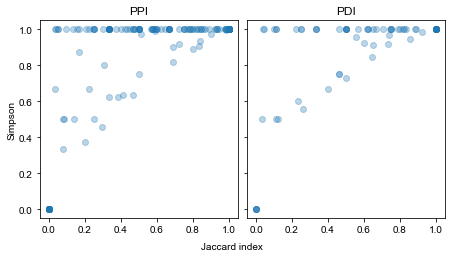

In [39]:
# Jaccard vs Simpson for PPI and PDI
def make_jaccard_simpson_plot(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

    alpha=0.3
    ax1.scatter(df.ppi_jaccard, df.ppi_simpson, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_aspect('equal')
    ax2.scatter(df.pdi_jaccard, df.pdi_simpson, alpha=alpha)
    ax2.set_title('PDI')
    ax2.set_aspect('equal')

    fig.tight_layout()
    fig.text(0.5, 0.05, 'Jaccard index', ha='center')
    fig.text(-0.02, 0.5, 'Simpson', va='center', rotation='vertical')

make_jaccard_simpson_plot(iso_pairs) # only plotted for cases  with 1+ interactions for both iso. of a pair

SignificanceResult(statistic=nan, pvalue=nan)

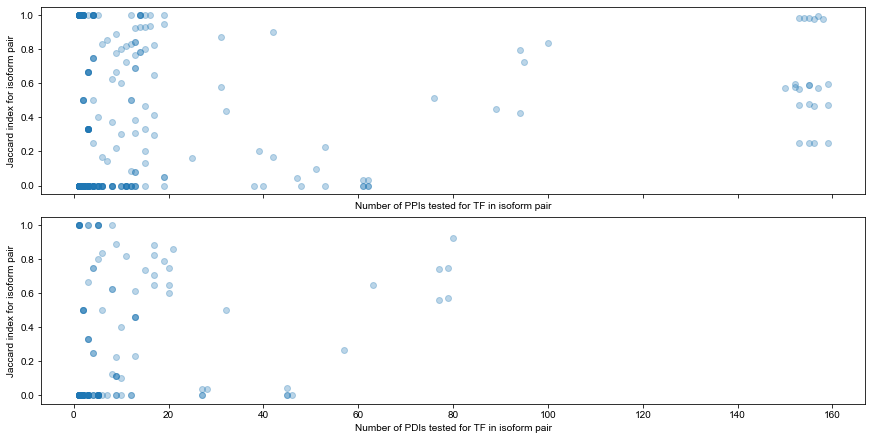

In [40]:
# Is there a relationship between degree and interaction profile similarity?
# For now use number of pdi/ppi tested as estimate of degree.
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(12,6))
alpha=0.3

ax1.scatter(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard, alpha=alpha)
ax1.set_xlabel('Number of PPIs tested for TF in isoform pair')
ax1.set_ylabel('Jaccard index for isoform pair')

ax2.scatter(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard, alpha=alpha)
ax2.set_xlabel('Number of PDIs tested for TF in isoform pair')
ax2.set_ylabel('Jaccard index for isoform pair')

fig.tight_layout()

# Luke question - how to determine if there is no bias between degree and Jaccard?
stats.spearmanr(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard)
stats.spearmanr(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard)

In [41]:
iso_pairs.sort_values(['ppi_jaccard', 'aa_seq_pct_id'], ascending=[True, False])

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,pdi_n_max
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TFEC|5/6|04A01_TFEC|6/6|03E11,TFEC,TFEC|5/6|04A01,TFEC|6/6|03E11,4.0,0.0,0.0,0.0,0.0,NaN,4.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.5,False,False,False,TFEC-5,TFEC-6,NaN
RBPJ|1/4|01F06_RBPJ|2/4|07B11,RBPJ,RBPJ|1/4|01F06,RBPJ|2/4|07B11,2.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.279541,3.736935,-0.457394,0.457394,99.0,True,True,True,RBPJ-1,RBPJ-2,NaN
GRHL3|2/7|08A10_GRHL3|3/7|08G09,GRHL3,GRHL3|2/7|08A10,GRHL3|3/7|08G09,2.0,0.0,0.0,0.0,0.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.248480,0.436213,0.187733,0.187733,98.4,False,False,True,GRHL3-2,GRHL3-3,NaN
NFIA|2/5|02G09_NFIA|3/5|02E09,NFIA,NFIA|2/5|02G09,NFIA|3/5|02E09,1.0,0.0,0.0,0.0,0.0,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.340298,4.185884,-1.845586,1.845586,98.2,False,False,False,NFIA-2,NFIA-3,NaN
RBPJ|1/4|01F06_RBPJ|3/4|07D11,RBPJ,RBPJ|1/4|01F06,RBPJ|3/4|07D11,2.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.736935,3.987183,0.250248,0.250248,98.2,True,True,True,RBPJ-1,RBPJ-3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFP1|2/4|04D02_ZFP1|4/4|04C01,ZFP1,ZFP1|2/4|04D02,ZFP1|4/4|04C01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.617791,0.339418,0.957208,0.957208,2.1,False,False,False,ZFP1-2,ZFP1-4,NaN
ZFP1|1/4|04C02_ZFP1|4/4|04C01,ZFP1,ZFP1|1/4|04C02,ZFP1|4/4|04C01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.005591,0.339418,2.345009,2.345009,2.0,False,False,False,ZFP1-1,ZFP1-4,NaN
ZNF180|1/4|10E12_ZNF180|4/4|02C10,ZNF180,ZNF180|1/4|10E12,ZNF180|4/4|02C10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.593331,0.323311,0.916642,0.916642,1.6,False,False,False,ZNF180-1,ZNF180-4,NaN


SignificanceResult(statistic=0.516570352675714, pvalue=2.5505817371755523e-21)


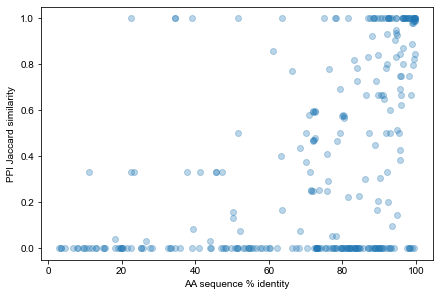

In [42]:
x = iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull(), 'ppi_jaccard'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('PPI Jaccard similarity')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../figures/ppi_jaccard_vs_aa_id.pdf',
            bbox_inches='tight')

SignificanceResult(statistic=0.41013485100729025, pvalue=1.0401312590624848e-06)


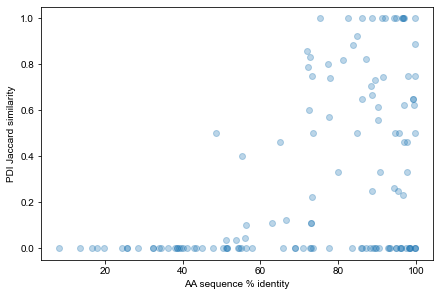

In [43]:
x = iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(), 'pdi_jaccard'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('PDI Jaccard similarity')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../figures/pdi_jaccard_vs_aa_id.pdf',
            bbox_inches='tight')

SignificanceResult(statistic=0.029775877050930308, pvalue=0.4614404723869955)


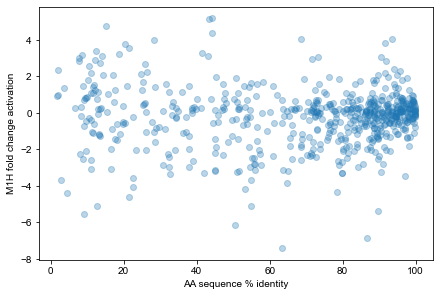

In [44]:
x = iso_pairs.loc[iso_pairs['activation_fold_change'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['activation_fold_change'].notnull(), 'activation_fold_change'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('M1H fold change activation')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../figures/m1h_fold_change_vs_aa_id.pdf',
            bbox_inches='tight')

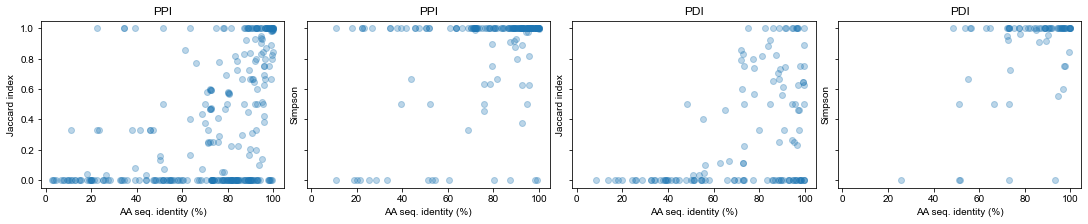

In [45]:
# Jaccard/Simpson versus similarity for PPI and PDI
def make_profile_diff_vs_seq_plot(df):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15,3))
    fig.tight_layout()
    (ax1, ax2, ax3, ax4) = axs
    
    for ax in axs: ax.set_xlabel('AA seq. identity (%)')
        
    alpha=0.3
    
    ax1.scatter(df.aa_seq_pct_id, df.ppi_jaccard, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_ylabel('Jaccard index')
    ax2.scatter(df.aa_seq_pct_id, df.ppi_simpson, alpha=alpha)
    ax2.set_title('PPI')
    ax2.set_ylabel('Simpson')
    ax3.scatter(df.aa_seq_pct_id, df.pdi_jaccard, alpha=alpha)
    ax3.set_title('PDI')
    ax3.set_ylabel('Jaccard index')
    ax4.scatter(df.aa_seq_pct_id, df.pdi_simpson, alpha=alpha)
    ax4.set_title('PDI')
    ax4.set_ylabel('Simpson')

make_profile_diff_vs_seq_plot(iso_pairs)

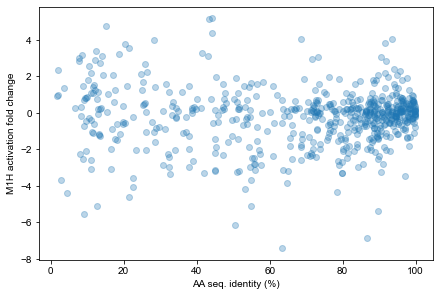

In [46]:
# Jaccard/Simpson versus similarity for M1H
fig, ax1 = plt.subplots(1, sharex=True, sharey=True)
fig.tight_layout()
alpha=0.3
ax1.scatter(iso_pairs.aa_seq_pct_id, iso_pairs.activation_fold_change, alpha=alpha)
ax1.set_xlabel('AA seq. identity (%)')
ax1.set_ylabel('M1H activation fold change')
plt.savefig('../figures/M1H_fold_change_vs_aa_id.pdf',
            bbox_inches='tight')

In [47]:
# get isoform-specific y1h and y2h degree
deg = y1h.loc[:, y1h.columns[2:]].sum(axis=1).rename('y1h_degree')
y1h_nd = y1h[['tf', 'unique_acc']].join(deg, how='left')
y2h_nd = y2h.loc[y2h.category=='tf_isoform_ppis', :].groupby('ad_clone_acc')['ad_clone_acc'].count().rename('y2h_degree')
int_nd = y1h_nd.join(y2h_nd, how='outer', on='unique_acc')
int_nd.head()

,tf,unique_acc,y1h_degree,y2h_degree
0.0,CREB1,CREB1|1/2|02E01,0.0,NaN
1.0,CREB1,CREB1|2/2|01F12,4.0,NaN
2.0,DLX1,DLX1|1/2|07A12,3.0,NaN
3.0,DLX1,DLX1|2/2|07E09,0.0,NaN
4.0,DLX4,DLX4|1/3|11A04,1.0,NaN


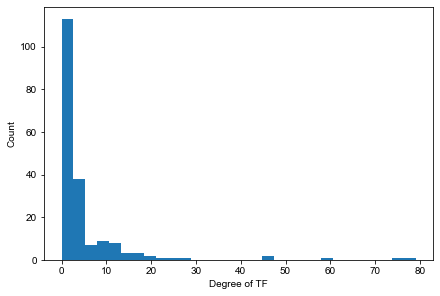

Text(0, 0.5, 'Count')

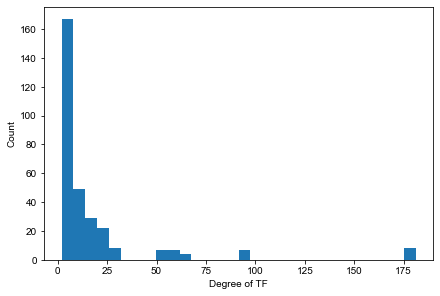

In [48]:
# plot the degree distributions
# degere of y1h
plt.hist(int_nd.y1h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')
plt.show()
plt.hist(int_nd.y2h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')

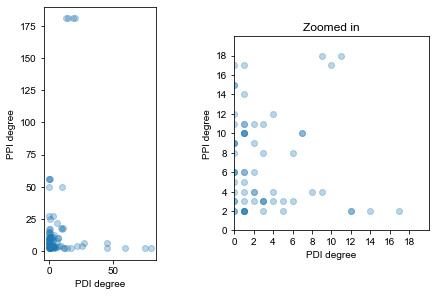

In [49]:
# compare pdi versus ppi degree
fig, (ax1, ax2) = plt.subplots(1,2)
alpha = 0.3

ax1.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax1.set_aspect('equal')
ax1.set_xlabel('PDI degree')
ax1.set_ylabel('PPI degree')

ax2.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax2.set_aspect('equal')
ax2.set_xlabel('PDI degree')
ax2.set_ylabel('PPI degree')
ax2.set_title('Zoomed in')
ax2.set_xlim(0,20)
ax2.set_xticks(range(0,20,2))
ax2.set_ylim(0,20)
ax2.set_yticks(range(0,20,2));
# ax2.set_yscale('log')
# ax2.set_xscale('log')


SignificanceResult(statistic=0.02393793519039485, pvalue=0.713899525680243)


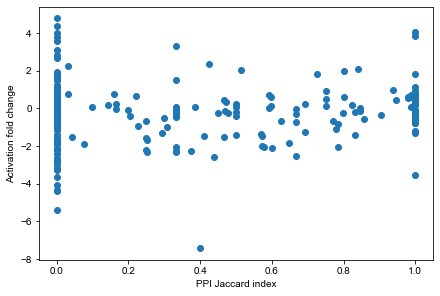

In [50]:
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
plt.scatter(xy[x], xy[y])
plt.xlabel('PPI Jaccard index')
plt.ylabel('Activation fold change')
print(stats.spearmanr(xy[x], xy[y]))
plt.savefig('../figures/ppi_vs_activation.pdf',
            bbox_inches='tight')

(111, 30)
SignificanceResult(statistic=0.14111656307222825, pvalue=0.13958755965427294)


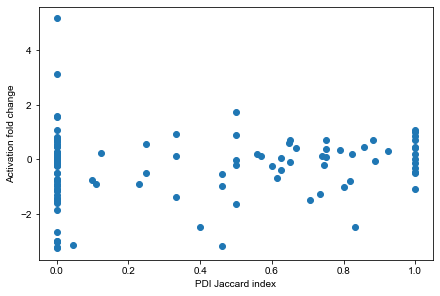

In [51]:
x = 'pdi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y])
plt.xlabel('PDI Jaccard index')
plt.ylabel('Activation fold change')
print(stats.spearmanr(xy[x], xy[y]))
plt.savefig('../figures/pdi_vs_activation.pdf',
            bbox_inches='tight')

(50, 30)


SignificanceResult(statistic=0.26173812246673683, pvalue=0.06634129656583246)

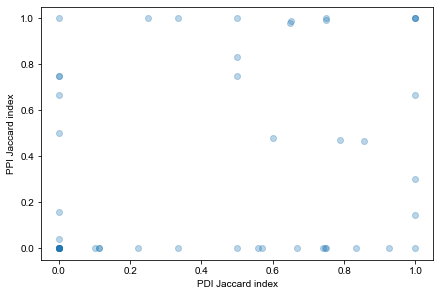

In [52]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [53]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
print(iso_pairs['ppi_n_min']>=1)
print(iso_pairs[x].notnull())

pair
AEBP2|2/3|05F03_AEBP2|3/3|05E07        False
ARNT2|1/6|08C12_ARNT2|2/6|09E01         True
ARNT2|1/6|08C12_ARNT2|3/6|10D11        False
ARNT2|2/6|09E01_ARNT2|3/6|10D11        False
ARNTL|1/2|08H08_ARNTL|2/2|08E08        False
                                       ...  
ZSCAN26|1/2|02H03_ZSCAN26|2/2|02D03    False
ZSCAN32|1/5|05B06_ZSCAN32|2/5|05F05    False
ZSCAN32|1/5|05B06_ZSCAN32|4/5|05H04    False
ZSCAN32|2/5|05F05_ZSCAN32|4/5|05H04    False
ZSCAN9|1/3|11H08_ZSCAN9|2/3|08H02       True
Name: ppi_n_min, Length: 804, dtype: bool
pair
AEBP2|2/3|05F03_AEBP2|3/3|05E07        False
ARNT2|1/6|08C12_ARNT2|2/6|09E01        False
ARNT2|1/6|08C12_ARNT2|3/6|10D11        False
ARNT2|2/6|09E01_ARNT2|3/6|10D11        False
ARNTL|1/2|08H08_ARNTL|2/2|08E08        False
                                       ...  
ZSCAN26|1/2|02H03_ZSCAN26|2/2|02D03    False
ZSCAN32|1/5|05B06_ZSCAN32|2/5|05F05    False
ZSCAN32|1/5|05B06_ZSCAN32|4/5|05H04    False
ZSCAN32|2/5|05F05_ZSCAN32|4/5|05H04    False
ZSC

(18, 30)


SignificanceResult(statistic=-0.2660252368939488, pvalue=0.2859717579179636)

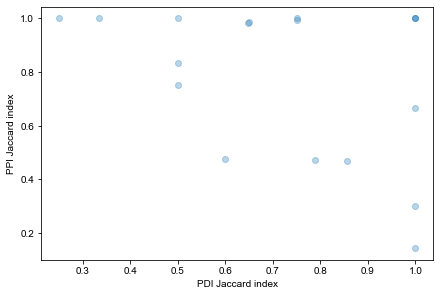

In [54]:
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull() & (iso_pairs['ppi_n_min']>=1) & (iso_pairs['pdi_n_min']>=1), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [55]:
# Look at direction of activation change? I.e. is the isoform with less binding partners
# the one with activation closer to 0?

In [56]:
iso_pairs.sort_values('ppi_n_min_diff',
                      ascending=False).head(20)

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,pdi_n_max
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZBTB44|1/9|12B06_ZBTB44|4/9|10H06,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|4/9|10H06,17.0,5.0,11.0,6.0,0.294118,0.454545,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.102926,0.222032,-1.324958,1.324958,76.0,True,True,True,ZBTB44-1,ZBTB44-4,NaN
TCF4|5/9|07C02_TCF4|7/9|07G03,TCF4,TCF4|5/9|07C02,TCF4|7/9|07G03,100.0,84.0,90.0,6.0,0.840000,0.933333,16.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.336326,4.427035,2.090708,2.090708,89.8,True,True,True,TCF4-5,TCF4-7,NaN
TCF4|5/9|07C02_TCF4|8/9|07A05,TCF4,TCF4|5/9|07C02,TCF4|8/9|07A05,95.0,69.0,75.0,6.0,0.726316,0.920000,26.0,-14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.336326,4.161332,1.825006,1.825006,89.1,True,True,True,TCF4-5,TCF4-8,NaN
ZBTB44|4/9|10H06_ZBTB44|6/9|12H02,ZBTB44,ZBTB44|4/9|10H06,ZBTB44|6/9|12H02,15.0,3.0,8.0,5.0,0.200000,0.375000,12.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.223177,-1.102926,-0.120251,0.120251,92.5,True,True,True,ZBTB44-4,ZBTB44-6,NaN
ZBTB44|1/9|12B06_ZBTB44|5/9|10H05,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|5/9|10H05,17.0,7.0,11.0,4.0,0.411765,0.636364,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.271681,0.222032,-1.493713,1.493713,75.8,True,True,True,ZBTB44-1,ZBTB44-5,NaN
ZBTB44|1/9|12B06_ZBTB44|3/9|10B06,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|3/9|10B06,15.0,7.0,11.0,4.0,0.466667,0.636364,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.303344,0.222032,-1.525376,1.525376,78.6,True,True,True,ZBTB44-1,ZBTB44-3,NaN
ZBTB44|3/9|10B06_ZBTB44|6/9|12H02,ZBTB44,ZBTB44|3/9|10B06,ZBTB44|6/9|12H02,13.0,5.0,8.0,3.0,0.384615,0.625000,8.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.303344,-1.223177,0.080167,0.080167,95.7,True,True,True,ZBTB44-3,ZBTB44-6,NaN
ZBTB44|5/9|10H05_ZBTB44|6/9|12H02,ZBTB44,ZBTB44|5/9|10H05,ZBTB44|6/9|12H02,15.0,5.0,8.0,3.0,0.333333,0.625000,10.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.271681,-1.223177,0.048504,0.048504,92.3,True,True,True,ZBTB44-5,ZBTB44-6,NaN
ZNF451|6/8|05H11_ZNF451|7/8|06D01,ZNF451,ZNF451|6/8|05H11,ZNF451|7/8|06D01,5.0,0.0,2.0,2.0,0.000000,0.000000,5.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.661738,2.146779,1.485041,1.485041,52.9,True,True,True,ZNF451-6,ZNF451-7,NaN


In [57]:
# Check if this result is robust against requiring at least
# one interaction partner for both genes.
# To see if the effect is driven by non-functional isoforms.
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() &
                   iso_pairs[y].notnull() &
                   (iso_pairs['ppi_n_min'] >= 1), :]
print(xy.shape)
stats.spearmanr(xy[x], xy[y])

(142, 30)


SignificanceResult(statistic=0.09833782676892114, pvalue=0.24430350413944826)

In [58]:
xy.sort_values('activation_fold_change', ascending=False).head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,pdi_n_max
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NR4A1|1/5|03A04_NR4A1|2/5|03G05,NR4A1,NR4A1|1/5|03A04,NR4A1|2/5|03G05,2.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495597,4.524734,4.029137,4.029137,93.6,True,True,True,NR4A1-1,NR4A1-2,NaN
ATF2|3/6|09C05_ATF2|5/6|09A05,ATF2,ATF2|3/6|09C05,ATF2|5/6|09A05,3.0,0.0,1.0,1.0,0.0,0.0,3.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.344877,3.668095,4.012971,4.012971,28.3,True,True,True,ATF2-3,ATF2-5,NaN
NR4A1|1/5|03A04_NR4A1|3/5|03G02,NR4A1,NR4A1|1/5|03A04,NR4A1|3/5|03G02,2.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495597,4.332042,3.836445,3.836445,91.6,True,True,True,NR4A1-1,NR4A1-3,NaN
ATF2|4/6|09B05_ATF2|5/6|09A05,ATF2,ATF2|4/6|09B05,ATF2|5/6|09A05,3.0,0.0,1.0,1.0,0.0,0.0,3.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.125596,3.668095,3.793690,3.793690,20.3,True,True,True,ATF2-4,ATF2-5,NaN
ZSCAN18|1/7|09F02_ZSCAN18|2/7|09A01,ZSCAN18,ZSCAN18|1/7|09F02,ZSCAN18|2/7|09A01,10.0,0.0,1.0,1.0,0.0,0.0,10.0,-8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200202,3.773076,3.572874,3.572874,21.4,True,True,True,ZSCAN18-1,ZSCAN18-2,NaN


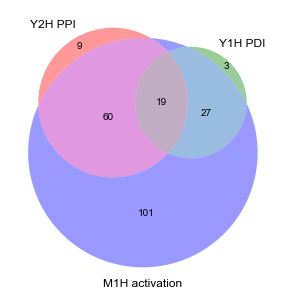

In [59]:
# overlaps

a = set(iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull(), 'tf_gene_symbol'].unique())
b = set(iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(), 'tf_gene_symbol'].unique())
c = set(iso_pairs.loc[iso_pairs['activation_fold_change'].notnull(), 'tf_gene_symbol'].unique())
from matplotlib_venn import venn3

venn3([a, b, c],
      set_labels=['Y2H PPI', 'Y1H PDI', 'M1H activation'])
plt.savefig('../figures/tf_gene_data_integration_venn.pdf')

In [61]:
ppi['Y2H_result'].value_counts()

True     2173
False    1568
Name: Y2H_result, dtype: int64

In [62]:
ppi['Y2H_result'].notnull().sum() / ppi.shape[0]

0.9795758051846033

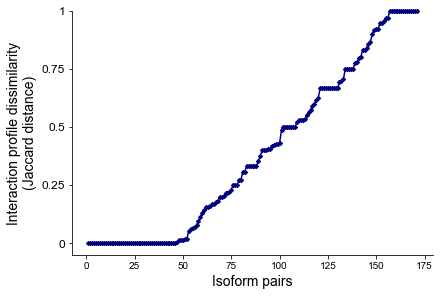

In [63]:
def remake_yang_et_al_fig_2b(values, color='navy'):
    ax.plot(range(1, values.shape[0] + 1),
            sorted(values),
            marker='D',
            markersize=3,
            color=color,
            clip_on=False)
    ax.set_xlabel('Isoform pairs', fontsize=14)
    ax.set_ylabel('Interaction profile dissimilarity\n(Jaccard distance)',
                  fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{:g}'.format(t) for t in ax.get_yticks()],
                       fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], 1)
    

fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull() &
                       (iso_pairs['ppi_n_min'] >= 1),
                       'ppi_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../figures/remake_yang_et_al_fig4B.pdf',
            bbox_inches='tight')

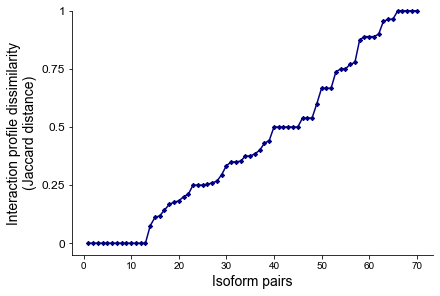

In [64]:
fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull() &
                       (iso_pairs['pdi_n_min'] >= 1),
                       'pdi_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../figures/remake_yang_et_al_fig4B_PDI.pdf',
            bbox_inches='tight')

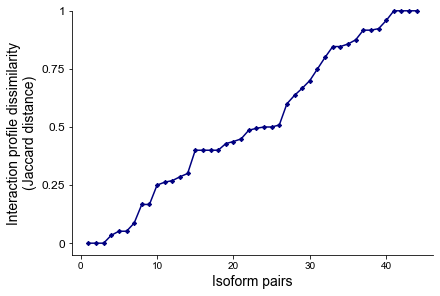

In [65]:
# combine PPI and PDI
iso_pairs['ppi_pdi_jaccard'] = ((iso_pairs['ppi_n_shared'] + iso_pairs['pdi_n_shared']) / 
                                (iso_pairs['ppi_n_tested'] + iso_pairs['pdi_n_tested']))
fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) | (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../figures/remake_yang_et_al_fig4B_combine_PDI_PPI.pdf',
            bbox_inches='tight')

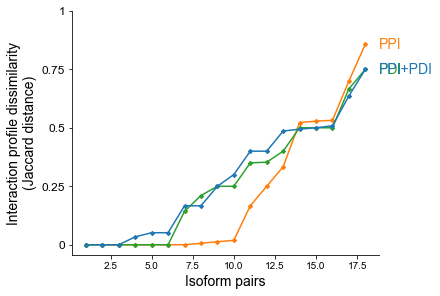

In [66]:
# all on one plot
fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'pdi_jaccard'].values
values_ppi_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
remake_yang_et_al_fig_2b(values_ppi, color='C1')
remake_yang_et_al_fig_2b(values_pdi, color='C2')
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        values_pdi.max(), 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_all_one_plot.pdf',
            bbox_inches='tight')

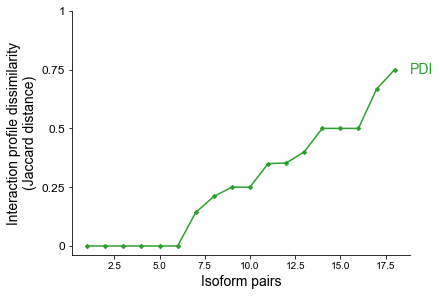

In [67]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_pdi, color='C2')
ax.text(ax.get_xlim()[1], 
        values_pdi.max(), 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
plt.savefig('../figures/remake_yang_et_al_fig4B_PDI.pdf',
            bbox_inches='tight')

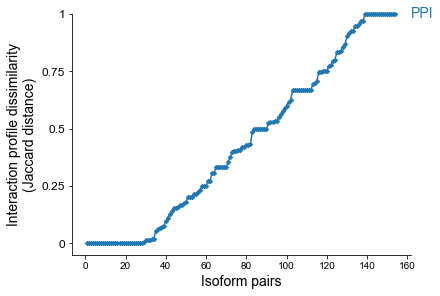

In [68]:
# TEMP: make with (2020-07-30)
ys = 1 - iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2)
               & iso_pairs['both_iso_y2h_pos'],
               'ppi_jaccard'].values


fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(ys, color='C0')
ax.text(ax.get_xlim()[1], 
        ys.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C0')
plt.savefig('../figures/ppi_jaccard_20200730.pdf',
            bbox_inches='tight')

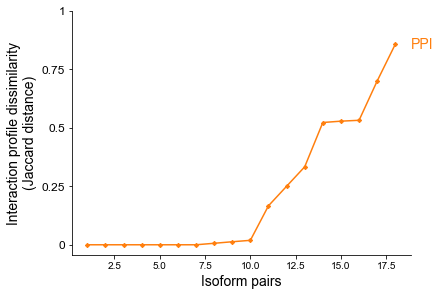

In [69]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_ppi, color='C1')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
plt.savefig('../figures/remake_yang_et_al_fig4B_PPI.pdf',
            bbox_inches='tight')

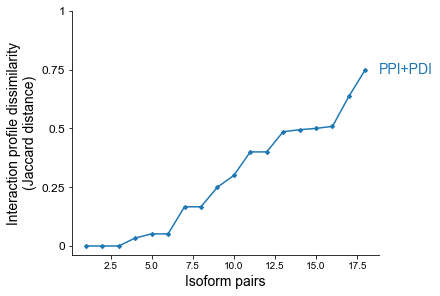

In [70]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_both.pdf',
            bbox_inches='tight')

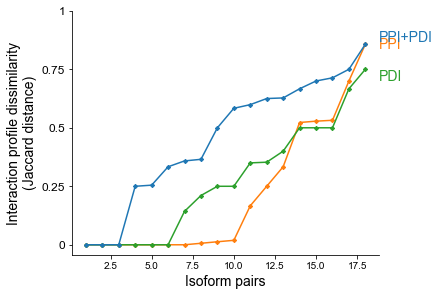

In [71]:
# product
fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'pdi_jaccard'].values
values_ppi_pdi = 1 - (iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_jaccard'].values
                     * iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'pdi_jaccard'].values)
remake_yang_et_al_fig_2b(values_ppi, color='C1')
remake_yang_et_al_fig_2b(values_pdi, color='C2')
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        values_pdi.max() - 0.03, 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max() + 0.03, 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_all_one_plot_product.pdf',
            bbox_inches='tight')

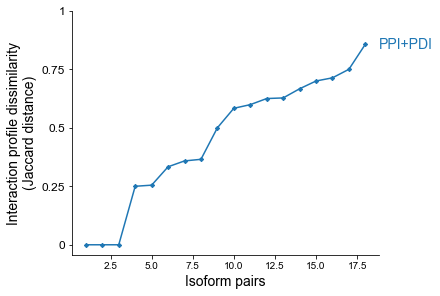

In [72]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_pdi_ppi_product.pdf',
            bbox_inches='tight')

In [73]:
values_ppi

array([0.25      , 0.        , 0.        , 0.        , 0.        ,
       0.16666667, 0.00636943, 0.01290323, 0.53205128, 0.01898734,
       0.52830189, 0.52258065, 0.85714286, 0.33333333, 0.7       ,
       0.        , 0.        , 0.        ])

In [74]:
values_ppi_pdi

array([0.625     , 0.25      , 0.66666667, 0.75      , 0.5       ,
       0.58333333, 0.25477707, 0.3583871 , 0.5989011 , 0.3652271 ,
       0.62760675, 0.71354839, 0.85714286, 0.33333333, 0.7       ,
       0.        , 0.        , 0.        ])

(array([7., 1., 1., 2., 2., 2., 1., 0., 1., 1.]),
 array([0.   , 0.075, 0.15 , 0.225, 0.3  , 0.375, 0.45 , 0.525, 0.6  ,
        0.675, 0.75 ]),
 <BarContainer object of 10 artists>)

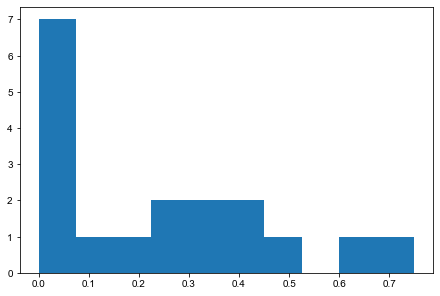

In [75]:
plt.hist(values_ppi_pdi - values_ppi)

In [76]:
stats.ttest_rel(values_ppi, values_ppi_pdi)

TtestResult(statistic=-4.179136325976531, pvalue=0.0006293380550003792, df=17)

In [77]:
stats.wilcoxon(values_ppi, values_ppi_pdi)

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=0.0, pvalue=0.002217721464237049)

In [78]:
stats.ks_2samp(values_ppi, values_ppi_pdi)

KstestResult(statistic=0.4444444444444444, pvalue=0.05601816779525039, statistic_location=0.16666666666666663, statistic_sign=1)

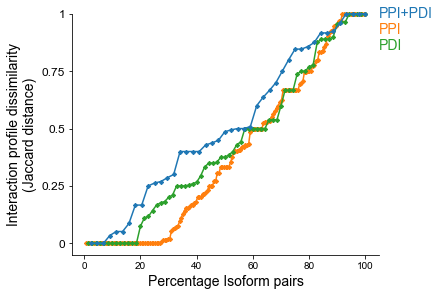

In [79]:
def remake_yang_et_al_fig_2b_pct_x(values, color='navy'):
    ax.plot(np.linspace(0, 100, values.shape[0] + 1)[1:],
            sorted(values),
            marker='D',
            markersize=3,
            color=color,
            clip_on=False)
    ax.set_xlabel('Percentage Isoform pairs', fontsize=14)
    ax.set_ylabel('Interaction profile dissimilarity\n(Jaccard distance)',
                  fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{:g}'.format(t) for t in ax.get_yticks()],
                       fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], 1)


fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1)),
                       'ppi_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull() &
                       ((iso_pairs['pdi_n_min'] >= 1)),
                       'pdi_jaccard'].values
values_ppi_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) | (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
remake_yang_et_al_fig_2b_pct_x(values_ppi, color='C1')
remake_yang_et_al_fig_2b_pct_x(values_pdi, color='C2')
remake_yang_et_al_fig_2b_pct_x(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        0.93, 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        0.86, 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        1, 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_all_one_plot_pct_isoforms.pdf',
            bbox_inches='tight')

In [80]:
stats.ks_2samp(values_ppi, values_ppi_pdi)

KstestResult(statistic=0.2359117490696438, pvalue=0.033341484624099915, statistic_location=0.019230769230769273, statistic_sign=1)

In [81]:
stats.ks_2samp(values_pdi, values_ppi_pdi)

KstestResult(statistic=0.1961038961038961, pvalue=0.2130386906068895, statistic_location=0.3846153846153846, statistic_sign=1)

In [82]:
iso_pairs.loc[(iso_pairs['pdi_jaccard'] == 0) &
              (iso_pairs['pdi_n_min'] >= 1), :]

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,pdi_n_max,ppi_pdi_jaccard
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MAX|1/6|08G02_MAX|4/6|08A03,MAX,MAX|1/6|08G02,MAX|4/6|08A03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,0.0,1.0,1.0,0.0,0.0,46.0,-44.0,-1.486114,1.755586,-3.241700,3.241700,51.1,False,False,True,MAX-1,MAX-4,45.0,NaN
MAX|3/6|08E02_MAX|4/6|08A03,MAX,MAX|3/6|08E02,MAX|4/6|08A03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,1.0,1.0,0.0,0.0,3.0,-1.0,-1.486114,-1.370046,-0.116067,0.116067,93.3,False,False,True,MAX-3,MAX-4,2.0,NaN
PKNOX1|2/4|06H05_PKNOX1|4/4|06G03,PKNOX1,PKNOX1|2/4|06H05,PKNOX1|4/4|06G03,3.0,0.0,0.0,0.0,0.0,NaN,3.0,-3.0,9.0,0.0,1.0,1.0,0.0,0.0,9.0,7.0,1.414036,2.368409,-0.954373,0.954373,73.1,False,True,True,PKNOX1-2,PKNOX1-4,8.0,0.0
PPARG|2/4|10F03_PPARG|4/4|10H03,PPARG,PPARG|2/4|10F03,PPARG|4/4|10H03,5.0,0.0,0.0,0.0,0.0,NaN,5.0,-5.0,2.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.801302,2.212049,-1.410747,1.410747,51.4,False,False,True,PPARG-2,PPARG-4,1.0,0.0
STAT1|2/7|03H01_STAT1|5/7|03C01,STAT1,STAT1|2/7|03H01,STAT1|5/7|03C01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.752057,1.224113,0.472056,0.472056,25.6,False,False,True,STAT1-2,STAT1-5,1.0,NaN
